In [1]:
import numpy as np
import pandas as pd
from rdflib import Graph, Literal, RDF, URIRef, Namespace
import networkx as nx
from node2vec import Node2Vec
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline

In [2]:
csv_file_path = "sample_dataset.csv"
rdf_output_path = "output_data.ttl"
node2vec_output_path = "node2vec_embeddings.vec"
transe_output_path = "transe_model"

In [3]:
def csv_to_rdf(csv_file_path, rdf_output_path):
    data = pd.read_csv(csv_file_path)
    g = Graph()
    EX = Namespace("http://example.org/")
    g.bind("ex", EX)
    
    for _, row in data.iterrows():
        user = URIRef(EX[f"user/{row['User-ID']}"])
        book = URIRef(EX[f"book/{row['ISBN']}"])
        rating = Literal(row['Book-Rating'])
        author = Literal(row['Book-Author'])
        title = Literal(row['Book-Title'])

        g.add((user, RDF.type, EX.User))
        g.add((book, RDF.type, EX.Book))
        g.add((user, EX.rated, book))
        g.add((book, EX.rating, rating))
        g.add((book, EX.author, author))
        g.add((book, EX.title, title))
    
    g.serialize(destination=rdf_output_path, format="turtle")
    return rdf_output_path

In [4]:
def rdf_to_networkx(rdf_file_path):
    rdf_graph = Graph()
    rdf_graph.parse(rdf_file_path, format="turtle")
    nx_graph = nx.DiGraph()
    for subj, pred, obj in rdf_graph:
        nx_graph.add_edge(str(subj), str(obj), predicate=str(pred))
    return nx_graph

In [5]:
def generate_node2vec_embeddings(nx_graph, output_path, dimensions=64, walk_length=30, num_walks=200, workers=4):
    node2vec = Node2Vec(nx_graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    model.wv.save_word2vec_format(output_path)
    return output_path

In [6]:
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
import numpy as np

def train_transe(rdf_file_path, output_path, num_epochs=100):
    rdf_graph = Graph()
    rdf_graph.parse(rdf_file_path, format="turtle")
    
    triples = [(str(subj), str(pred), str(obj)) for subj, pred, obj in rdf_graph]
    
    triples_array = np.array(triples, dtype=object)
    if triples_array.ndim != 2 or triples_array.shape[1] != 3:
        raise ValueError("Triples must be a 2D array with three columns (head, relation, tail).")
    
    triples_factory = TriplesFactory.from_labeled_triples(triples=triples_array)
    train_factory, test_factory, validation_factory = triples_factory.split([0.8, 0.1, 0.1])
    
    result = pipeline(
        training=train_factory,  
        testing=test_factory,    
        validation=validation_factory,
        model="TransE",
        training_kwargs=dict(num_epochs=num_epochs),
    )
    result.save_to_directory(output_path)
    return output_path

In [7]:
if __name__ == "__main__":
    print("Converting CSV to RDF...")
    rdf_file = csv_to_rdf(csv_file_path, rdf_output_path)
    
    print("Converting RDF to NetworkX graph...")
    nx_graph = rdf_to_networkx(rdf_file)
    
    print("Generating Node2Vec embeddings...")
    node2vec_file = generate_node2vec_embeddings(nx_graph, node2vec_output_path)
    print(f"Node2Vec embeddings saved to: {node2vec_file}")

Converting CSV to RDF...
Converting RDF to NetworkX graph...
Generating Node2Vec embeddings...


Computing transition probabilities:   0%|          | 0/15558 [00:00<?, ?it/s]

Node2Vec embeddings saved to: node2vec_embeddings.vec


Loading embeddings and text data...
Vectorizing and reducing text data...
Vectorizing text data...
Reducing dimensionality to 50...
Combining embeddings...
Clustering embeddings...
Visualizing clusters...


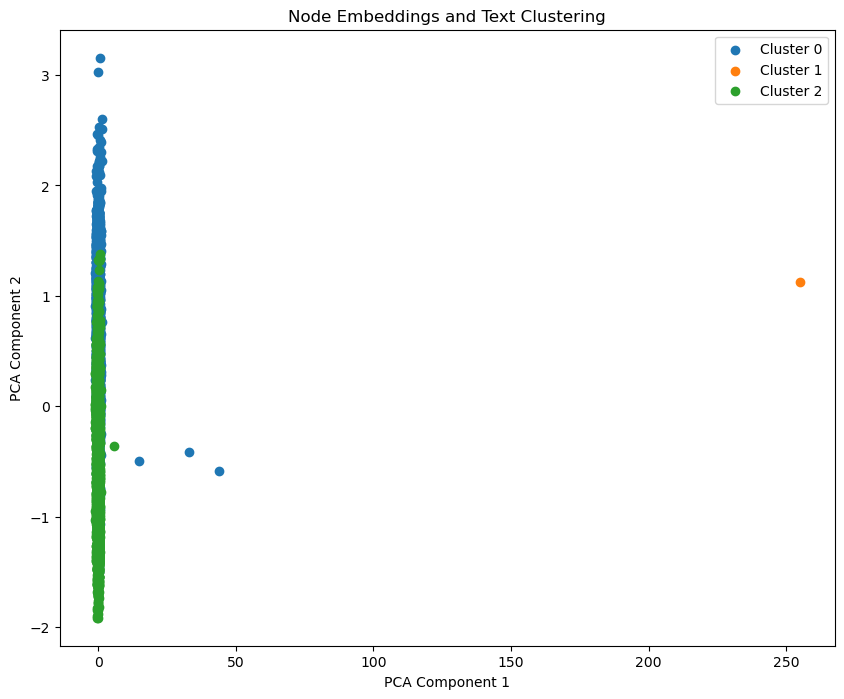

In [8]:
import os
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

def load_embeddings_with_text(vec_file_path):
    with open(vec_file_path, 'r') as f:
        lines = f.readlines()
    
    node_embeddings = {}
    text_data = {}
    for line in lines[1:]: 
        parts = line.strip().split()
        node_id = parts[0]
        try:
            embedding = np.array([float(x) for x in parts[1:]])
            node_embeddings[node_id] = embedding
        except ValueError:
            text_data[node_id] = " ".join(parts[1:])
    return node_embeddings, text_data

def vectorize_and_reduce_text_data(text_data, n_components=50):
    vectorizer = TfidfVectorizer(max_features=50000)
    text_ids = list(text_data.keys())
    text_corpus = list(text_data.values())
    
    print("Vectorizing text data...")
    text_vectors = vectorizer.fit_transform(text_corpus)
    
    print(f"Reducing dimensionality to {n_components}...")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_text_vectors = svd.fit_transform(text_vectors)
    
    return text_ids, reduced_text_vectors

def combine_embeddings_optimized(node_embeddings, text_ids, text_vectors, text_vector_dim):
    embeddings = []
    numeric_dim = len(next(iter(node_embeddings.values()))) if node_embeddings else 0
    max_num_dims = numeric_dim + text_vector_dim

    for node_id, numeric_embedding in node_embeddings.items():
        try:
            if text_vectors is not None and node_id in text_ids:
                text_index = text_ids.index(node_id)
                text_embedding = text_vectors[text_index]
                combined = np.concatenate([numeric_embedding, text_embedding])
            else:
                combined = np.concatenate([numeric_embedding, np.zeros(max_num_dims - numeric_dim)])
            embeddings.append(combined)
        except Exception as e:
            print(f"Error processing node {node_id}: {e}")
            continue

    max_len = max(len(emb) for emb in embeddings)
    embeddings = [np.pad(emb, (0, max_len - len(emb))) for emb in embeddings]
    
    return np.array(embeddings)

def cluster_embeddings(embeddings, num_clusters):
    clustering = AgglomerativeClustering(n_clusters=num_clusters)
    cluster_labels = clustering.fit_predict(embeddings)
    return cluster_labels

def visualize_clusters(embeddings, cluster_labels):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    for cluster_id in np.unique(cluster_labels):
        cluster_points = reduced_embeddings[cluster_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
    
    plt.title("Node Embeddings and Text Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    vec_file_path = 'node2vec_embeddings.vec'

    print("Loading embeddings and text data...")
    node_embeddings, text_data = load_embeddings_with_text(vec_file_path)

    print("Vectorizing and reducing text data...")
    if text_data:
        text_ids, text_vectors = vectorize_and_reduce_text_data(text_data, n_components=50)
    else:
        text_ids, text_vectors = [], None

    print("Combining embeddings...")
    combined_embeddings = combine_embeddings_optimized(node_embeddings, text_ids, text_vectors, text_vector_dim=50)

    print("Clustering embeddings...")
    num_clusters = 3
    cluster_labels = cluster_embeddings(combined_embeddings, num_clusters)

    print("Visualizing clusters...")
    visualize_clusters(combined_embeddings, cluster_labels)


In [9]:
import numpy as np
import rdflib
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import torch

def load_rdf_as_triples(rdf_file_path):
    rdf_graph = rdflib.Graph()
    rdf_graph.parse(rdf_file_path, format="turtle") 
    triples = [(str(subj), str(pred), str(obj)) for subj, pred, obj in rdf_graph]
    return triples


# Step 2: 使用 TransE 训练模型
def train_transe_model_from_rdf(rdf_file_path, output_path, num_epochs=100):

    triples = load_rdf_as_triples(rdf_file_path)

    triples_array = np.array(triples, dtype=str)
    triples_factory = TriplesFactory.from_labeled_triples(triples=triples_array)

    result = pipeline(
        training=triples_factory,
        testing=triples_factory, 
        validation=None,         
        model="TransE",
        training_kwargs=dict(num_epochs=num_epochs),
    )

    result.save_to_directory(output_path)

    return result, triples_factory


def predict_top_books(user_id, triples_factory, model_result, top_n=5):

    trained_model = model_result.model
    entity_to_id = triples_factory.entity_to_id
    id_to_entity = {v: k for k, v in entity_to_id.items()}

    if user_id not in entity_to_id:
        raise ValueError(f"USER-ID {user_id} does not exist")

    user_embedding = trained_model.entity_representations[0](torch.tensor([entity_to_id[user_id]]))

    all_entities = list(entity_to_id.keys())
    similarities = []
    for entity in all_entities:
        if entity.startswith("Book-Title"):
            entity_embedding = trained_model.entity_representations[0](torch.tensor([entity_to_id[entity]]))
            similarity = -np.linalg.norm(user_embedding.detach().numpy() - entity_embedding.detach().numpy())
            similarities.append((entity, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    top_books = [entity for entity, _ in similarities[:top_n]]
    return [id_to_entity[book] for book in top_books]

In [10]:
import torch

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    rdf_file = "output_data.ttl"
    transe_output_path = "transe_model_output" 
    user_id = "108759" 
    top_n = 5 

    transe_result, trained_triples_factory = train_transe_model_from_rdf(
        rdf_file, transe_output_path, num_epochs=100
    )

No random seed is specified. Setting to 1401076238.


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/120 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/30.7k [00:00<?, ?triple/s]

C:\Users\Lenovo\anaconda3\Lib\site-packages\pykeen\utils.py:508: RuntimeWarning: overflow encountered in scalar add
  return sum(
INFO:pykeen.evaluation.evaluator:Evaluation took 35.57s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=15558, num_relations=5, create_inverse_triples=False, num_triples=30718) to file:///C:/Users/Lenovo/Desktop/Knowledge%20management/transe_model_output/training_triples
INFO:pykeen.pipeline.api:Saved to directory: C:\Users\Lenovo\Desktop\Knowledge management\transe_model_output


In [11]:
import torch
from pykeen.triples import TriplesFactory
from pykeen.models import Model
import os
import pandas as pd
import rdflib

def load_transe_model(model_directory):
    model_path = os.path.join(model_directory, "trained_model.pkl")
    
    model = torch.load(model_path, map_location=torch.device('cpu'))
    return model

def predict_top_books(user_id, triples_factory, model, top_n=5):
    if user_id not in triples_factory.entity_to_id:
        raise ValueError(f"USER-ID {user_id} dose not exist")
    
    entity_embeddings = model.entity_representations[0]
    all_entities = list(triples_factory.entity_to_id.keys())
    user_idx = triples_factory.entity_to_id[user_id]
    user_idx_tensor = torch.tensor([user_idx], dtype=torch.long)
    user_embedding = entity_embeddings(user_idx_tensor).detach().numpy().squeeze()
    
    similarities = []
    for idx, entity in enumerate(all_entities):
        if entity.startswith("http://example.org/book"):
            entity_idx_tensor = torch.tensor([idx], dtype=torch.long)
            entity_embedding = entity_embeddings(entity_idx_tensor).detach().numpy().squeeze()
            similarity = -((user_embedding - entity_embedding) ** 2).sum()
            similarities.append((entity, similarity))
    
    top_books = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]
    return [book for book, _ in top_books]

if __name__ == "__main__":
    rdf_file_path = "output_data.ttl"
    model_directory = "transe_model_output"
    user_id = "http://example.org/user/100301"
    top_n = 5

    transe_model = load_transe_model(model_directory)

    rdf_graph = rdflib.Graph()
    rdf_graph.parse(rdf_file_path, format="turtle")
    triples = [(str(subj), str(pred), str(obj)) for subj, pred, obj in rdf_graph]
    triples_array = pd.DataFrame(triples).to_numpy(dtype=str)
    trained_triples_factory = TriplesFactory.from_labeled_triples(triples=triples_array)

    try:
        recommended_books = predict_top_books(user_id, trained_triples_factory, transe_model, top_n=top_n)
        print(f"{user_id} Recommendations")
        for idx, book in enumerate(recommended_books, 1):
            print(f"{idx}. {book}")
    except ValueError as e:
        print(e)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19092\2876940828.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('

http://example.org/user/100301 Recommendations
1. http://example.org/book/1563896699
2. http://example.org/book/0786011955
3. http://example.org/book/0441004326
4. http://example.org/book/0840758634
5. http://example.org/book/0812522079
